# An Analysis of Wind Speeds in the North Sea

---

### Data

We will be working with [data](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/) collected by [DWD](https://dwd.de) on Helgoland in a 10-minute intervall from 1996 to 2022. For loading the data, we have to manually collect the from a http server.


### Imports and Usage

You can simply use the `environment.yml` file to create a new conda environment with all the needed packages by running `conda env create -f environment.yml`. The only relevant parameter you may want to change is `RELOAD`. If set to `True`, all the needed data will be downloaded and saved in the `data/` folder.

# Purpose of this notebook:
In this notebook, after basic data exploration and preprocessing, we primarily investigated:
- the goodness-of-fit for the different Weibull models we obtained for different estimators.
- the trend in the Weibull parameters, which fully chahracterize the PDFs, and the implications for other quantities.

All numbers and polts corresponding to these sections in the paper are produced here.



## Data Loading

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib as mpl
import seaborn as sns
import datetime as dt
import matplotlib.dates as mdt
from tueplots import bundles
import tueplots as tp
import tueplots.constants.color as tpc
from tueplots import cycler
import math
from datetime import datetime

import scipy.optimize as opt
import scipy.integrate
import scipy


from sklearn.gaussian_process import GaussianProcessRegressor as GP
import sklearn.gaussian_process.kernels as GPK
import joypy as jpy
import os
from sklearn.linear_model import LinearRegression
from scipy.stats import permutation_test
import pyhomogeneity as hg

import sys
sys.path.append("../util/")
from dataloader import Loader
from weibull import Weibull
from ridgeline_plot import ridgeline_plot

from sklearn.metrics import mean_squared_error
from helpers import plot_timeframe, plot_timeframe_pdf, yearly_params, monthly_params, pettitt_test, snh_test

def full_fig(nrows=1, ncols=1):
    plt.rcParams.update(bundles.icml2022(column="full"))
def half_fig(nrows=1, ncols=1):
    plt.rcParams.update(bundles.icml2022(column="half"))
def set_dpi(dpi):
    plt.rcParams.update({"figure.dpi": dpi})


plt.rcParams.update(cycler.cycler(color=tp.constants.color.palettes.tue_plot))
plt.rcParams.update(bundles.icml2022(column="full"))
plt.rcParams["font.family"] = "DejaVu Sans"

# set true to download the data and unzip into the current directory
RELOAD = False
ZIP_NAME = "data.zip"
DATA_FOLDER = "../data"
FIGURE_FOLDER = "../paper/fig"

DATA_BASE_URL = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/"
METRICS = ["wind", "air_temperature", "precipitation", "solar"]
METRIC_URLS = [DATA_BASE_URL + postfix + "/historical/" for postfix in METRICS]
print(METRIC_URLS)

['https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/wind/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/air_temperature/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/precipitation/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/solar/historical/']


In [2]:
loader = Loader(METRICS, DATA_FOLDER)
metric_files = loader.download_all_metrics(reset=False)

for kind in METRICS:
    print(f"Files containing {kind} data:\n\t{metric_files[kind]}")

kind_df, df = loader.as_dataframe

Files containing wind data:
	['c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\wind\\produkt_zehn_min_ff_19961220_19991231_02115.txt', 'c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\wind\\produkt_zehn_min_ff_20000101_20091231_02115.txt', 'c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\wind\\produkt_zehn_min_ff_20100101_20191231_02115.txt', 'c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\wind\\produkt_zehn_min_ff_20200101_20221231_02115.txt']
Files containing air_temperature data:
	['c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\air_temperature\\produkt_zehn_min_tu_19961219_19991231_02115.txt', 'c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\air_temperature\\produkt_zehn_min_tu_20000101_20091231_02115.txt', 'c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\air_temperature\\produkt_zehn_min_tu_20100101_20191231_02115

In [3]:
for metric, metric_df in kind_df.items():
    print(metric_df.dtypes)

STATIONS_ID             int64
MESS_DATUM     datetime64[ns]
  QN_wind               int64
FF_10_wind            float64
DD_10_wind            float64
eor_wind               object
dtype: object
STATIONS_ID                        int64
MESS_DATUM                datetime64[ns]
QN_air_temperature               float64
PP_10_air_temperature            float64
TT_10_air_temperature            float64
TM5_10_air_temperature           float64
RF_10_air_temperature            float64
TD_10_air_temperature            float64
  QN_air_temperature             float64
eor_air_temperature               object
dtype: object
STATIONS_ID                          int64
MESS_DATUM                  datetime64[ns]
QN_precipitation                   float64
RWS_DAU_10_precipitation           float64
RWS_10_precipitation               float64
RWS_IND_10_precipitation           float64
  QN_precipitation                 float64
eor_precipitation                   object
dtype: object
STATIONS_ID             

## Preprocessing

In [4]:
wind_df = kind_df["wind"]
wind_df["year"] = wind_df["MESS_DATUM"].dt.year
wind_df["month"] = wind_df["MESS_DATUM"].dt.month
wind_df["day"] = wind_df["MESS_DATUM"].dt.day

# First, get rid of NaNs

# a bit more than one year across all years is missing (~ 58000 days) (most of it in 2019)
nans_by_year = wind_df[wind_df["FF_10_wind"].isna()].groupby("year")["STATIONS_ID"].count().reset_index() 
nans_by_year.columns = ["year", "#NaNs"]
print(nans_by_year)
print(f"#NaNs: {wind_df['FF_10_wind'].isna().sum()}")
wind_df.dropna(subset=["FF_10_wind"], inplace=True)
wind_df = wind_df[wind_df["FF_10_wind"] != -999]
rest_df = wind_df.groupby("year")["FF_10_wind"].count().reset_index()
rest_df.columns = ["year", "count"]
rest_df["count"] /= 24 * 6 * 365.25
print('The roughly estimated percentage of valid measurements by year:' )
print(rest_df)

    year  #NaNs
0   2000      4
1   2001     10
2   2002     30
3   2003      5
4   2007      8
5   2009    217
6   2013   1578
7   2014     62
8   2015    196
9   2016   1056
10  2017   1040
11  2018   4868
12  2019  46074
13  2020    950
14  2021   1819
15  2022    277
#NaNs: 58194
The roughly estimated percentage of valid measurements by year:
    year     count
0   1996  0.029641
1   1997  0.848334
2   1998  0.837953
3   1999  0.997433
4   2000  1.001730
5   2001  0.998403
6   2002  0.998023
7   2003  0.994714
8   2004  0.999924
9   2005  0.998992
10  2006  0.998042
11  2007  0.999163
12  2008  1.002053
13  2009  0.995190
14  2010  0.999316
15  2011  0.999316
16  2012  1.002053
17  2013  0.969313
18  2014  0.998137
19  2015  0.995589
20  2016  0.981976
21  2017  0.979542
22  2018  0.906761
23  2019  0.123317
24  2020  0.983991
25  2021  0.906229
26  2022  0.994049


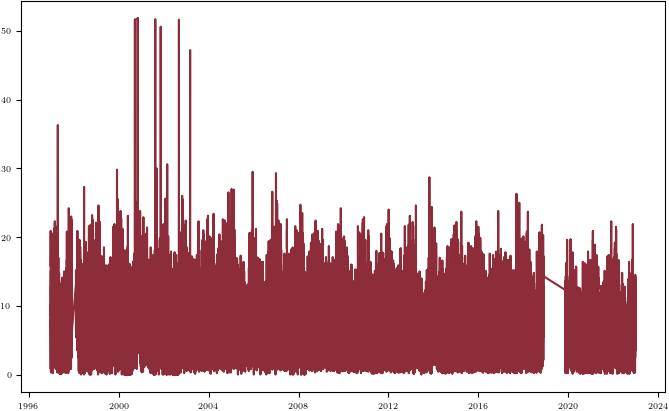

In [5]:
# there are still some outlier left
plt.plot("MESS_DATUM", "FF_10_wind", data=wind_df)
plt.show()

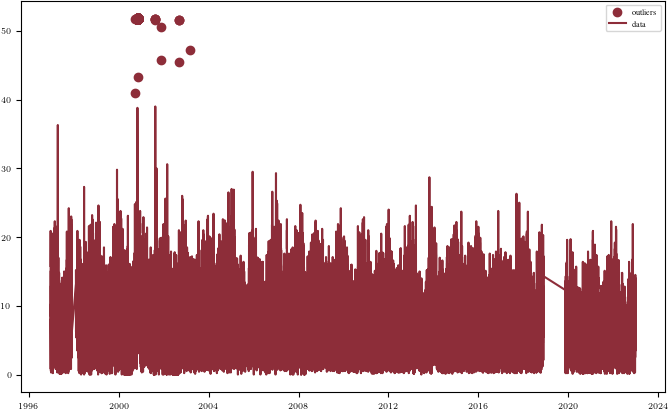

1158


In [6]:
# We choose to exclude the measurements that are above a certain threshold 
# We also exclude the data after month where the large measurement break takes place
#( e.g. in Winter 2000 there is an entire week that yields conctantly 50 m/s, which is very unlikely to refelect the actual wind situation)
zscores = scipy.stats.zscore(wind_df["FF_10_wind"])
threshold = 8

cut_off=pd.to_datetime('2018-11-01')
plt.scatter("MESS_DATUM", "FF_10_wind", data=wind_df[zscores > threshold], label='outliers')
plt.plot("MESS_DATUM", "FF_10_wind", data=wind_df[(zscores <= threshold)], label='data' )
plt.legend()
plt.show()
print(wind_df[(zscores > threshold) ].STATIONS_ID.count())


In [7]:
wind_df = wind_df[zscores < 8]

wind_df

,STATIONS_ID,MESS_DATUM,QN_wind,FF_10_wind,DD_10_wind,eor_wind,year,month,day
0,2115,1996-12-19 10:40:00,1,15.8,70.0,eor,1996,12,19
1,2115,1996-12-19 10:50:00,1,16.2,70.0,eor,1996,12,19
2,2115,1996-12-19 11:00:00,1,16.6,70.0,eor,1996,12,19
3,2115,1996-12-19 11:10:00,1,16.0,80.0,eor,1996,12,19
4,2115,1996-12-19 11:20:00,1,16.3,70.0,eor,1996,12,19
...,...,...,...,...,...,...,...,...,...
154742,2115,2022-12-31 23:10:00,3,13.6,230.0,eor,2022,12,31
154743,2115,2022-12-31 23:20:00,3,12.4,230.0,eor,2022,12,31
154744,2115,2022-12-31 23:30:00,3,12.6,230.0,eor,2022,12,31
154745,2115,2022-12-31 23:40:00,3,12.6,230.0,eor,2022,12,31


## Explorative Data Analysis

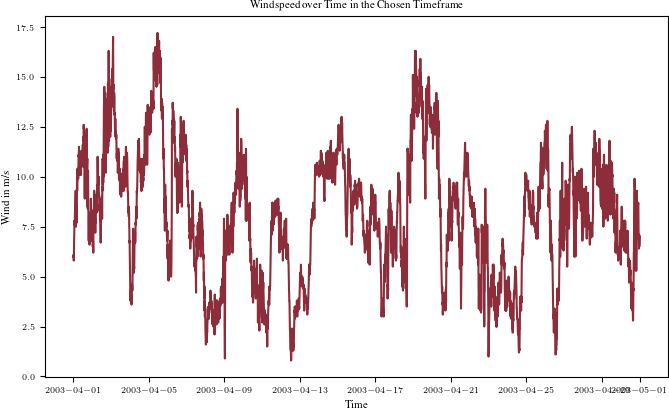

In [8]:
# plot exemplary a chosen timeframe

plot_timeframe(df, 2003, 4)

# Start Fitting Weibull Distributions

The Weibull distributions are suposed to model the wind speed frequencies we observed. 
We estimate the Weibull parameters both on a monthly and a yearly basis.

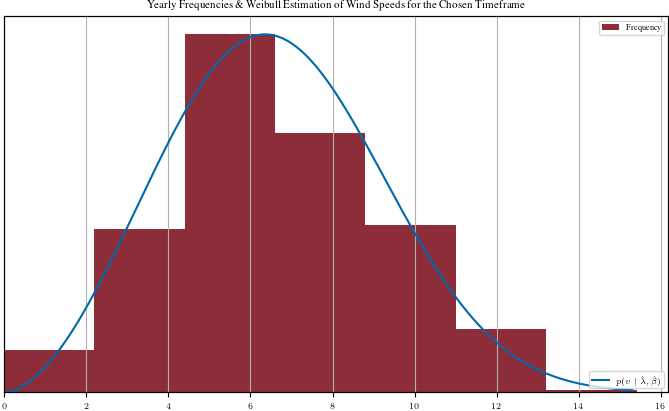

In [9]:
# plot the empiric pdf and the estimated weibull distribution for a chosen timeframe
plot_timeframe_pdf(df, 2002, 5)

In [10]:
# compute the weibull parameters for all months and years
yearly_df=yearly_params(1999, 2018, wind_df)
monthly_df=monthly_params(1999, 2018, wind_df)


In [11]:
# drop the months without valid values
monthly_df=monthly_df[monthly_df['param_lambda']>-1]

Text(0, 0.5, 'p(v $\\mid \\hat{\\lambda}, \\hat{\\beta}$)')

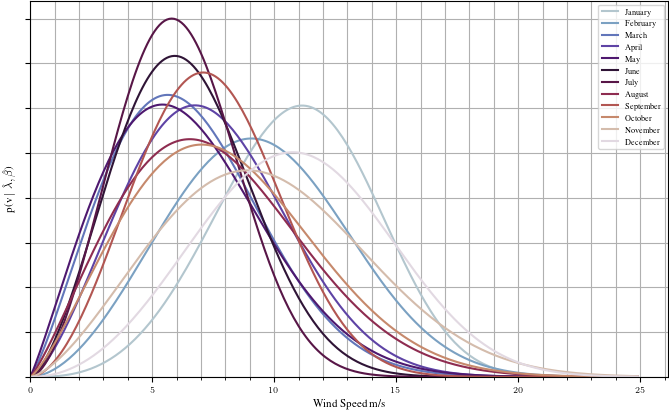

In [12]:
# plot the estimated weibull distributions of all the months of the year 2014

fig, ax = plt.subplots(1, 1)
month_colors = plt.cm.twilight(np.linspace(0,1,13))
for month in range(1,13):
    X = np.arange(0, 25, 0.1)
    target=pd.Period(f'{2014}-{month}', freq='M')
    weibull = Weibull(monthly_df.loc[target, 'param_lambda'],monthly_df.loc[target, 'param_beta'] )
    ax.plot(X, weibull.pdf(X), label=dt.datetime(2014, month, 1).strftime("%B"), color= month_colors[month])
    # ax.axvline(weibull.mean, ls="-.", linewidth=0.25)
    
ax.grid(which="both")
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1.0))
ax.set_yticklabels([])
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend()
ax.set_xlabel(r"Wind Speed m/s")
ax.set_ylabel(r"p(v $\mid \hat{\lambda}, \hat{\beta}$)")


Text(0, 0.5, '$\\mathrm{p}(\\mathrm{v} \\mid \\hat{\\lambda}, \\hat{\\beta})$')

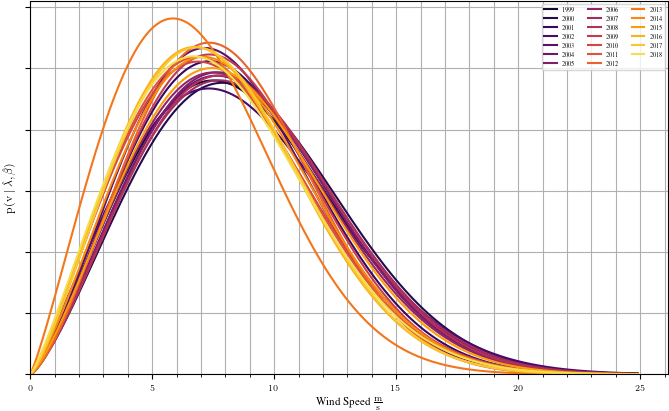

In [13]:
# plot the estimated weibull distribution for each year
fig, ax = plt.subplots(1, 1)
year_colors = plt.cm.inferno(np.linspace(0,1,24))
for year in yearly_df.index:
    X = np.arange(0, 25, 0.1)
    weibull = Weibull(yearly_df.loc[year, 'param_lambda'],yearly_df.loc[year, 'param_beta'] )
    ax.plot(X, weibull.pdf(X), label=year, color= year_colors[year-1997])
    # ax.axvline(weibull.mean, ls="-.", linewidth=0.25)
    
ax.grid(which="both")
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1.0))
ax.set_yticklabels([])
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend(ncols=(2022 - 1996) / 8, fontsize="xx-small")
ax.set_xlabel(r"Wind Speed $\frac{\mathrm{m}}{\mathrm{s}}$")
ax.set_ylabel(r"$\mathrm{p}(\mathrm{v} \mid \hat{\lambda}, \hat{\beta})$")

# Determine the Goodness Of Fit for the Models Obtained by Different Estimators

From a literature review, we chose three methods to estimate the Weibull parameters, namely the graphical method, the maximum likelihood method
and the energy pattern factor method. 
We implemented them and compared them according to several criteria, among them the RMSE, the KL-Divergence and the expected relative error per bin. 

The comparison did not make it into the paper, but we chose the MLM to work with, as it is the most accurate. 
Also the expected relative error per bin is used in the paper to gauge the goodness of fit. 

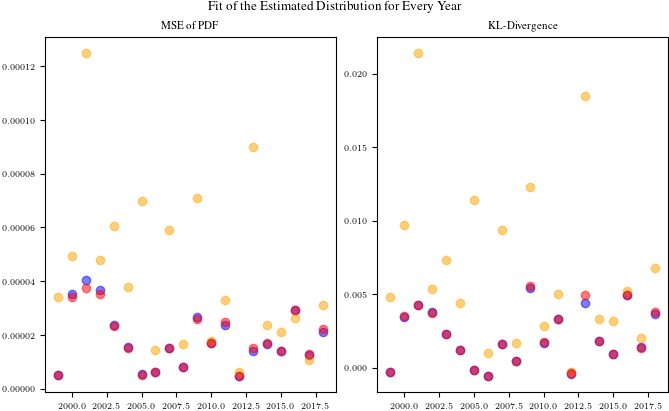

In [14]:
# How is the goodness-of-fit for every year?

figure, axis = plt.subplots(1, 2)

yearly_df['mle_RMSE']=0.0
yearly_df['graphical_RMSE']=0.0
yearly_df['epf_RMSE']=0.0

yearly_df['mle_divergence']=0.0
yearly_df['graphical_divergence']=0.0
yearly_df['epf_divergence']=0.0

for y in range(1999, 2019):
    #if y==2000:
    #    continue
    mle_weibull=Weibull.estimate(wind_df[(wind_df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    graphical_weibull=Weibull.graphical_estimate(wind_df[(wind_df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    epf_weibull=Weibull.epf_estimate(wind_df[(wind_df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    
    fit1= mle_weibull.fit(wind_df[(wind_df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    fit2=graphical_weibull.fit(wind_df[(wind_df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    fit3=epf_weibull.fit(wind_df[(wind_df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])

    yearly_df.loc[ y, 'mle_RMSE']=np.sqrt(fit1[0])
    yearly_df.loc[y, 'graphical_RMSE']=np.sqrt(fit2[0])
    yearly_df.loc[y,'epf_RMSE']=np.sqrt(fit3[0])

    yearly_df.loc[y,'mle_divergence']=fit1[4]
    yearly_df.loc[y,'graphical_divergence']=fit2[4]
    yearly_df.loc[y, 'epf_divergence']=fit3[4]

    axis[0].scatter(y,fit1[0], color='blue', alpha=0.5 , label='MLM') 
    axis[0].scatter(y, fit2[0], color='orange', alpha=0.5, label='graphical method')
    axis[0].scatter(y, fit3[0], color='red', alpha=0.5, label='epf method')
    axis[0].set_title("MSE of PDF")
    
    axis[1].scatter(y, fit1[4], color='blue', alpha=0.5) 
    axis[1].scatter(y, fit2[4], color='orange', alpha=0.5)
    axis[1].scatter(y, fit3[4], color='red', alpha=0.5)
    axis[1].set_title("KL-Divergence")

figure.suptitle('Fit of the Estimated Distribution for Every Year')
plt.show()

In [15]:
# find the average of the yearly RMSE and divergence resp
m_mle_RMSE=yearly_df['mle_RMSE'].mean()
m_graphical_RMSE=yearly_df['graphical_RMSE'].mean()
m_epf_RMSE=yearly_df['epf_RMSE'].mean()

m_mle_divergence=yearly_df['mle_divergence'].mean()
m_graphical_divergence=yearly_df['graphical_divergence'].mean()
m_epf_divergence=yearly_df['epf_divergence'].mean()

print(f'The means of the rmse for yearly fitting are:{m_mle_RMSE,m_graphical_RMSE,m_epf_RMSE  }')
print(f'The means of the divergence for yearly fitting are:{m_mle_divergence,m_graphical_divergence,m_epf_divergence  }')

The means of the rmse for yearly fitting are:(0.004125515817743319, 0.006131349313144399, 0.004113071400995881)
The means of the divergence for yearly fitting are:(0.0021560470417584963, 0.00676586743592337, 0.002192896106814984)


In [16]:
# how is the goodness-of-fit for every month?

monthly_df['mle_RMSE']=0.0
monthly_df['graphical_RMSE']=0.0
monthly_df['epf_RMSE']=0.0

monthly_df['mle_divergence']=0.0
monthly_df['graphical_divergence']=0.0
monthly_df['epf_divergence']=0.0

for m in monthly_df.index:
    mask=(wind_df['MESS_DATUM'].dt.year == m.year) & (wind_df['MESS_DATUM'].dt.month == m.month)

    #if len(wind_df[mask])==0:
    #    print(f'problem {m}')
    #    continue
    mle_weibull=Weibull.estimate(wind_df[mask]["FF_10_wind"])
    graphical_weibull=Weibull.graphical_estimate(wind_df[mask]["FF_10_wind"])
    epf_weibull=Weibull.epf_estimate(wind_df[mask]["FF_10_wind"])
    
    fit1= mle_weibull.fit(wind_df[mask]["FF_10_wind"])
    fit2=graphical_weibull.fit(wind_df[mask]["FF_10_wind"])
    fit3=epf_weibull.fit(wind_df[mask]["FF_10_wind"])

    monthly_df.loc[m, 'mle_RMSE']=np.sqrt(fit1[0])
    monthly_df.loc[m, 'graphical_RMSE']=np.sqrt(fit2[0])
    monthly_df.loc[m,'epf_RMSE']=np.sqrt(fit3[0])

    monthly_df.loc[m,'mle_divergence']=fit1[4]
    monthly_df.loc[m,'graphical_divergence']=fit2[4]
    monthly_df.loc[m, 'epf_divergence']=fit3[4]

    


In [17]:
# find the average of the monthly RMSE and divergence resp
m_mle_RMSE=monthly_df['mle_RMSE'].mean()
m_graphical_RMSE=monthly_df['graphical_RMSE'].mean()
m_epf_RMSE=monthly_df['epf_RMSE'].mean()

m_mle_divergence=monthly_df['mle_divergence'].mean()
m_graphical_divergence=monthly_df['graphical_divergence'].mean()
m_epf_divergence=monthly_df['epf_divergence'].mean()

print(f'The means of the rmse for monthly fitting are:{m_mle_RMSE,m_graphical_RMSE,m_epf_RMSE  }')
print(f'The means of the divergence for monthly fitting are:{m_mle_divergence,m_graphical_divergence,m_epf_divergence  }')


#monthly_df

The means of the rmse for monthly fitting are:(0.02270914412632009, 0.031766472684686166, 0.02346751519375164)
The means of the divergence for monthly fitting are:(0.01627975812508956, 0.0262732302413381, 0.017269532087437974)


Use the average relative error for the bins as a goodness of fit criterion:

In [18]:
# compute the expected relative error of a bin for each estimator and year
yearly_df['mle_rel_error']=0.0
yearly_df['graphical_rel_error']=0.0
yearly_df['epf_rel_error']=0.0
for y in yearly_df.index:
    frame=wind_df[(wind_df['MESS_DATUM'].dt.year == y)]["FF_10_wind"]

    mle_weibull=Weibull.estimate(frame)
    graphical_weibull=Weibull.graphical_estimate(frame)
    epf_weibull=Weibull.epf_estimate(frame)
    k=int(np.sqrt(len(frame)))+1 
    yearly_df.loc[ y, 'mle_rel_error']=mle_weibull.rel_fit( frame, k )
    yearly_df.loc[y, 'graphical_rel_error']=graphical_weibull.rel_fit( frame, k)
    yearly_df.loc[y,'epf_rel_error']=epf_weibull.rel_fit( frame, k)


#plt.plot( yearly_df.index ,yearly_df['mle_rel_error'])
print( f"The average yearly expected relative error per bin of the MLM (for bins chosen according to the squre root rule) is {yearly_df['mle_rel_error'].mean()}")


The average yearly expected relative error per bin of the MLM (for bins chosen according to the squre root rule) is 0.21973964455278444


In [19]:
# compute the expected relative error of a bin for each estimator and month

monthly_df['mle_rel_error']=0.0
monthly_df['graphical_rel_error']=0.0
monthly_df['epf_rel_error']=0.0

for m in monthly_df.index:
    mask=(wind_df['MESS_DATUM'].dt.year == m.year) & (wind_df['MESS_DATUM'].dt.month == m.month)
    frame=wind_df[mask]["FF_10_wind"]
    mle_weibull=Weibull.estimate(wind_df[mask]["FF_10_wind"])
    graphical_weibull=Weibull.graphical_estimate(wind_df[mask]["FF_10_wind"])
    epf_weibull=Weibull.epf_estimate(wind_df[mask]["FF_10_wind"])

    k=int( np.sqrt(len(wind_df[mask]["FF_10_wind"])))+1 
    monthly_df.loc[m, 'mle_rel_error']=mle_weibull.rel_fit( frame, k )
    monthly_df.loc[m, 'graphical_rel_error']=graphical_weibull.rel_fit( frame, k )
    monthly_df.loc[m,'epf_rel_error']=graphical_weibull.rel_fit( frame, k )

print( f"The average monthly expected relative error per bin of the MLM (for bins chosen according to the squre root rule) is {monthly_df['mle_rel_error'].mean()}")

The average monthly expected relative error per bin of the MLM (for bins chosen according to the squre root rule) is 0.22731172476134742


We plot the yearly Weibull PDFs obtained for all the months of a chosen year. 
Also one example for the fit, as well as the corresponding expected relative error per bin are provided, to allow the reader to put the value
of this goodness-of-fit criterion into perspective.

The expected relative error in December is 0.18111907173708108


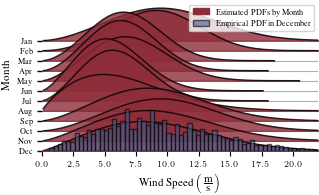

In [20]:
# do a ridgeline plot of the monthly pdfs in 2010
eval=2010
disp_df=monthly_df[ (monthly_df.index.year>eval-1) & (monthly_df.index.year<eval+1)]
full_fig()
X = np.arange(0, 25, 0.1) # 35 is the max plotted windspeed, 0.1 the steps
M=[]
for m in disp_df.index:
    weibull=Weibull(disp_df.loc[m, 'param_lambda'],disp_df.loc[m, 'param_beta'] )
    M.append(weibull.pdf(X))

half_fig()
fig, ax = plt.subplots()
m_labels=[ m.strftime('%b') for m in disp_df.index]
#m_labels = [ m.strftime('%b') if int(m.strftime('%m')[-1]) %3 == 1 else None for m in disp_df.index]
ridgeline_plot(np.tile(X, (len(M), 1)), np.array(M[::-1]), ax, m_labels[::-1], overlap=0.97, range_threshold=1e-5, alpha_density=0.8, fill_color_density=tp.constants.color.rgb.tue_red, fill_density=True)
ax.fill_between(X, np.full_like(X, 0), zorder=len(M)+1, color=tp.constants.color.rgb.tue_red, label='Estimated PDFs by Month')
frame=wind_df[(wind_df['MESS_DATUM'].dt.year==disp_df.index[-1].year) & (wind_df['MESS_DATUM'].dt.month==disp_df.index[-1].month)]
ax.hist(frame['FF_10_wind'], bins=int(np.sqrt(len(frame)))+1, color=tp.constants.color.rgb.tue_darkblue , edgecolor='black', alpha=0.6, density=True, zorder=len(M)+1, label='Empirical PDF in December')
ax.yaxis.grid(True)
#ax.xaxis.grid(True)
ax.yaxis.set_tick_params(width=1)
ax.set_xlabel(r"Wind Speed $ \big(\frac{\textrm{m}}{\textrm{s}} \big)$")
ax.set_ylabel("Month")
ax.set_xlim(0, 22)
ax.legend()

fig.savefig(os.path.join(FIGURE_FOLDER, "monthly_weibull.pdf"))

dec_weibull=Weibull.estimate(frame['FF_10_wind'])
dec_err=dec_weibull.rel_fit(frame['FF_10_wind'], int(np.sqrt(len(frame)))+1)
print(f'The expected relative error in December is {dec_err}')

# Analyze the Linear Trend in the Parameters

We conduct a least squares  linear regression on the Weibull parametrs and check the statistical significance with a permutation test. 
Further, the RMSE and the R^2 for both regression lines are determined. 

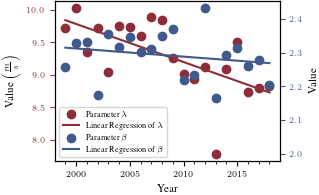

In [21]:
# plot the the parameters by year and do linear regresson
half_fig()
fig, ax1 = plt.subplots()

ax1.scatter(yearly_df.index, yearly_df['param_lambda'] , label=r'Parameter $\lambda$' )

l_pol=np.polyfit(yearly_df.index,yearly_df['param_lambda'], 1)
l_model = np.poly1d(l_pol)
ax1.plot(yearly_df.index,l_model(yearly_df.index), label=r'Linear Regression of $\lambda$')


ax2=ax1.twinx()

ax2.scatter(yearly_df.index, yearly_df['param_beta'] , label=r'Parameter $\beta$', color=tp.constants.color.rgb.tue_darkblue )

b_pol=np.polyfit(yearly_df.index,yearly_df['param_beta'], 1)
b_model = np.poly1d(b_pol)
ax2.plot(yearly_df.index,b_model(yearly_df.index) ,label=r'Linear Regression of $\beta$', color=tp.constants.color.rgb.tue_darkblue)

#plt.title('Developement of the Estimated Weibull-Parameters over Time')
ax2.set_ylabel('Value')
ax1.set_ylabel(r'Value $\big(\frac{m}{s} \big)$')
ax1.set_xlabel('Year')
ax1.tick_params('y', colors=tp.constants.color.rgb.tue_red)
ax2.tick_params('y', colors=tp.constants.color.rgb.tue_darkblue)

# set major ticks every 5 years
major_locator = MultipleLocator(5)
ax1.xaxis.set_major_locator(major_locator)

#set minor ticks every 1 year
minor_locator = MultipleLocator(1)
ax1.xaxis.set_minor_locator(minor_locator)



# make a good legend
ax1.plot(yearly_df.index, np.full_like(yearly_df.index, 8), alpha=0.0)

ax2.plot(yearly_df.index, np.full_like(yearly_df.index, 2), alpha=0.0)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='lower left')
fig.savefig(os.path.join(FIGURE_FOLDER, "linreg_parameters.pdf"))

The trend in beta is -0.0024203445379536222
The p-value for the trend in beta is 0.3734
The trend in lambda is -0.05862746317221279
The p-value for the trend in lambda is 0.0022


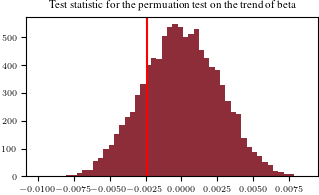

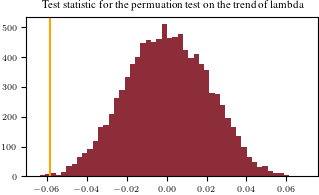

In [22]:
# do a permutation test to assess the statistical siginicance of the trends
# the test statistc of the permuation test is the slope of the linear regression
def regression_slope (Y: np.array,X=yearly_df.index):
    X=np.array(X).reshape(-1, 1)
    Y=np.array(Y).reshape(-1, 1)
    reg = LinearRegression().fit(X, Y)
    return (reg.coef_).item()


res1 = permutation_test(( yearly_df['param_beta'], ), regression_slope , permutation_type='pairings', vectorized=False, alternative='two-sided')
res2= permutation_test(( yearly_df['param_lambda'], ), regression_slope , permutation_type='pairings', vectorized=False, alternative='two-sided')
print(f'The trend in beta is {res1.statistic}')
print(f'The p-value for the trend in beta is {res1.pvalue}')

print(f'The trend in lambda is {res2.statistic}')
print(f'The p-value for the trend in lambda is {res2.pvalue}')

plt.hist(res1.null_distribution, bins=50, )
plt.axvline(x= res1.statistic, color='red')
plt.title('Test statistic for the permuation test on the trend of beta')
plt.show()

plt.hist(res2.null_distribution, bins=50,)
plt.axvline(x= res2.statistic, color='orange')
plt.title('Test statistic for the permuation test on the trend of lambda')
plt.show()


In [23]:
# evaluate the goodness of fit with the r^2 and the rmse
X=np.array(yearly_df.index).reshape(-1, 1)
Y1=np.array(yearly_df['param_lambda']).reshape(-1,1)
Y2=np.array(yearly_df['param_beta']).reshape(-1,1)

reg1 = LinearRegression().fit(X, Y1)
print(f'R^2 for lambda is {reg1.score(X, Y1)}')

reg2 = LinearRegression().fit(X, Y2)
print( f'R^2 for beta is {reg2.score(X, Y2)}')


# evaluate the goodness of fit with the RMSE
from sklearn.metrics import mean_squared_error
mse1=mean_squared_error(yearly_df['param_lambda'], reg1.predict(X) )

print(f'RMSE for lambda is {np.sqrt(mse1)}')
mse2=mean_squared_error(yearly_df['param_beta'], reg2.predict(X) )

print(f'RMSE for beta is {np.sqrt(mse2)}')


R^2 for lambda is 0.41644704772967145
R^2 for beta is 0.043571323008272045
RMSE for lambda is 0.40018164841172704
RMSE for beta is 0.06538813316796162


# Deduce the change in other quantities

As the parameters themselves might not easily interpretable, we deduce trends under the assumption that there is a trend in lambda,
and no trend in beta. For beta the mean of the years is chosen.

In [24]:
# decuce the change in other quantities 
beta_mean=yearly_df['param_beta'].mean()
print(f'The empiric mean for beta is {beta_mean}')
print(f'The trend in the mean is {res2.statistic*scipy.special.gamma(1 + 1 / beta_mean) }')

print(f'The value of the mean in 1997 is {reg1.predict(np.array([1997]).reshape(-1, 1))*scipy.special.gamma(1 + 1 / beta_mean) }')

print(f'The value of the mean in 2018 is {reg1.predict(np.array([2018]).reshape(-1, 1))*scipy.special.gamma(1 + 1 / beta_mean) }')

print(wind_df['FF_10_wind'].std())
print(f'The trend in the standard deviation is {res2.statistic*np.sqrt((scipy.special.gamma(1 + 2 / beta_mean) - scipy.special.gamma(1 + 1/ beta_mean)**2)) }')

print(f'The value of the standard deviation in 1999 is {reg1.predict(np.array([1999]).reshape(-1, 1))*np.sqrt((scipy.special.gamma(1 + 2 / beta_mean) - scipy.special.gamma(1 + 1/ beta_mean)**2)) }')

print(f'The value of the standard deviation in 2018 is {reg1.predict(np.array([2018]).reshape(-1, 1))*np.sqrt((scipy.special.gamma(1 + 2 / beta_mean) - scipy.special.gamma(1 + 1/ beta_mean)**2)) }')

weibull1999=Weibull(reg1.predict(np.array([1999]).reshape(-1, 1)).item(), beta_mean)
weibull2018=Weibull(reg1.predict(np.array([2018]).reshape(-1, 1)).item(), beta_mean)

print(f'prob of wind below 3 m/s in 1999: {weibull1999.cdf(np.array([3.0]))}')
print(f'prob of wind below 3 m/s in 2018:{(weibull2018).cdf(np.array([3.0]))}')
print(f'prob of wind above 22 m/s in 1999: {1-(weibull1999).cdf(np.array([10.0]))}')
print(f'prob of wind above 22 m/s in 2018: {1-(weibull2018).cdf(np.array([10.0]))}')

perc=1- reg1.predict(np.array([2018]).reshape(-1, 1)).item()**3/reg1.predict(np.array([1999]).reshape(-1, 1)).item()**3
print(f'The averaged power density drops form 1999 to 2018 by {perc} percent')

The empiric mean for beta is 2.2920351961457954
The trend in the mean is -0.05193692622979688
The value of the mean in 1997 is [[8.82338657]]
The value of the mean in 2018 is [[7.73271112]]
3.815271831509814
The trend in the standard deviation is -0.02402182903908575
The value of the standard deviation in 1999 is [[4.03294263]]
The value of the standard deviation in 2018 is [[3.57652788]]
prob of wind below 3 m/s in 1999: [0.06355342]
prob of wind below 3 m/s in 2018:[0.08283831]
prob of wind above 22 m/s in 1999: [0.35451905]
prob of wind above 22 m/s in 2018: [0.25522273]
The averaged power density drops form 1999 to 2018 by 0.30254095355006194 percent


We can also check how the trend in the parameters manifests in the PDFs:

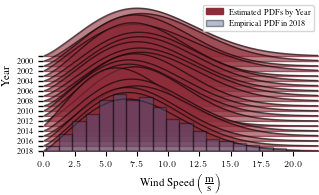

In [25]:
# Do a ridgline plot of the yearly Weibull distributions

X = np.arange(0, 25, 0.1) # 35 is the max plotted windspeed, 0.1 the steps
Y=[]
for y in yearly_df.index:
    weibull=Weibull(yearly_df.loc[y, 'param_lambda'],yearly_df.loc[y, 'param_beta'] )
    Y.append(weibull.pdf(X))

half_fig()
fig, ax = plt.subplots()
labels = [y if y % 2 == 0 else None for y in yearly_df.index]
ridgeline_plot(np.tile(X, (len(Y), 1)), np.array(Y[::-1]), ax, labels[::-1], overlap=0.99, range_threshold=1e-5, alpha_density=0.6, fill_color_density=tp.constants.color.rgb.tue_red, fill_density=True)
ax.fill_between(X, np.full_like(X, 0), zorder=len(Y)+1, color=tp.constants.color.rgb.tue_red, label='Estimated PDFs by Year')
frame=wind_df[wind_df['MESS_DATUM'].dt.year==yearly_df.index[-1]]
ax.hist(frame['FF_10_wind'], bins=int(0.1*np.sqrt(len(frame)))+1, color=tp.constants.color.rgb.tue_darkblue , edgecolor='black', alpha=0.4, density=True, zorder=len(Y)+1, label='Empirical PDF in 2018')
ax.yaxis.grid(True)
#ax.xaxis.grid(True)
ax.yaxis.set_tick_params(width=1)
ax.set_xlabel(r"Wind Speed $ \big(\frac{\textrm{m}}{\textrm{s}} \big)$")
ax.set_ylabel("Year")
ax.set_xlim(0, 22)
ax.legend()

fig.savefig(os.path.join(FIGURE_FOLDER, "yearly_weibull.pdf"))

# Check the Regression with Two Linear Line Segments
This did not make it into the paper. 
Authors proposed a reversal in global terestrial stilling, modelled by two linear segments and one breakpoint.

In [26]:
# This function  finds the best fit with count linear segments
# its from https://gist.github.com/ruoyu0088/70effade57483355bbd18b31dc370f2a
def segments_fit(X, Y, count):
    xmin = X.min()
    xmax = X.max()

    seg = np.full(count - 1, (xmax - xmin) / count)

    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < 3].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2)**2)

    r = opt.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')
    return func(r.x)


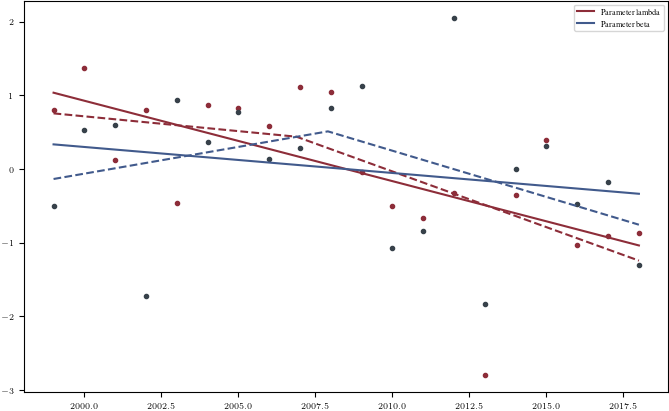

In [27]:
full_fig()
# check how the trend looks like with two conjoining line segments
X = yearly_df.index
ly=(yearly_df['param_lambda']- yearly_df['param_lambda'].mean())/(yearly_df['param_lambda'].std())
by=(yearly_df['param_beta']- yearly_df['param_beta'].mean())/(yearly_df['param_beta'].std())

px2, py2 = segments_fit(X, ly, 2)
bpx2, bpy2 = segments_fit(X, by, 2)

px1, py1 = segments_fit(X, ly, 1)
bpx1, bpy1 = segments_fit(X, by, 1)

Y2 = np.interp(X, px2, py2)
#print(np.sqrt(np.mean((ly- Y2)**2)))

plt.plot(X, ly, ".")
plt.plot(px2, py2, "--", color=tp.constants.color.rgb.tue_red)
plt.plot(px1, py1, color=tp.constants.color.rgb.tue_red, label="Parameter lambda")
plt.plot(X, by, ".")
plt.plot(bpx2, bpy2, "--", color=tp.constants.color.rgb.tue_darkblue)
plt.plot(bpx1, bpy1, color=tp.constants.color.rgb.tue_darkblue, label="Parameter beta")
plt.legend()
plt.show()

# Check for inhomogeneities in the measured data
This is a further indication to drop the data after 2019, but was not thoroughly investigated.
The drop in mean might be associated to a (not publicly documented) change of the measuring station.

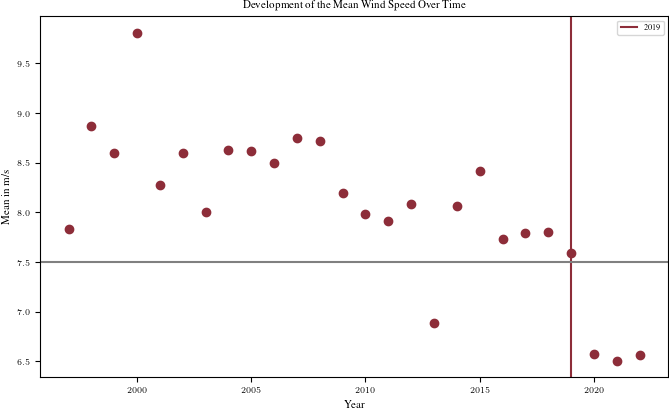

In [31]:
# plot the mean per year

X=df['FF_10_wind']
X=df[ (df['FF_10_wind']>0) & ~np.isnan(df['FF_10_wind'])]
mean_df=pd.DataFrame()
mean_df['Years']=np.arange(1997, 2023)
mean_df.set_index('Years', inplace=True)
mean_df['Mean']=0.0

for y in mean_df.index:
    mean_df.loc[y, 'Mean']=X[X['MESS_DATUM'].dt.year==y]['FF_10_wind'].mean() 

plt.scatter(mean_df.index,  mean_df['Mean'] )
plt.axvline(x=2019, label='2019')
plt.axhline(y=7.5, color='gray')
plt.title('Development of the Mean Wind Speed Over Time' )
plt.ylabel('Mean in m/s')
plt.xlabel('Year')
plt.legend()
plt.show()

Here follows the corresponding test statistic of the pettitt test and the snh test, when applied to the yearly mean. 
They are supposed to detect inhomogeneities. A thorough investigation would require to check other quantities as well.

Pettitt_Test(h=True, cp=13, p=0.0001, U=149.0, avg=mean(mu1=8.57008669572392, mu2=7.531332485828519))
SNHT_Test(h=True, cp=23, p=0.00095, T=12.770053789545104, avg=mean(mu1=8.24679957539576, mu2=6.547353042026397))


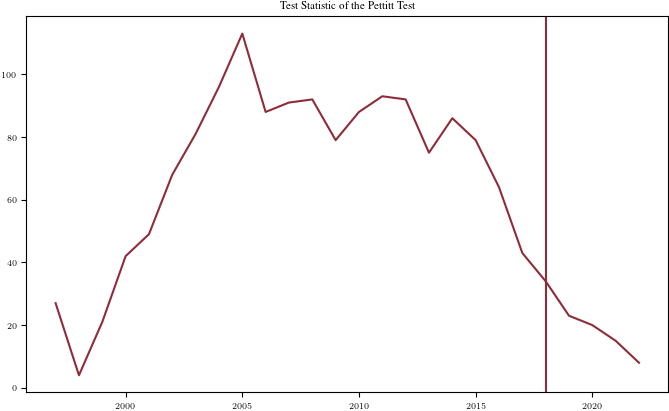

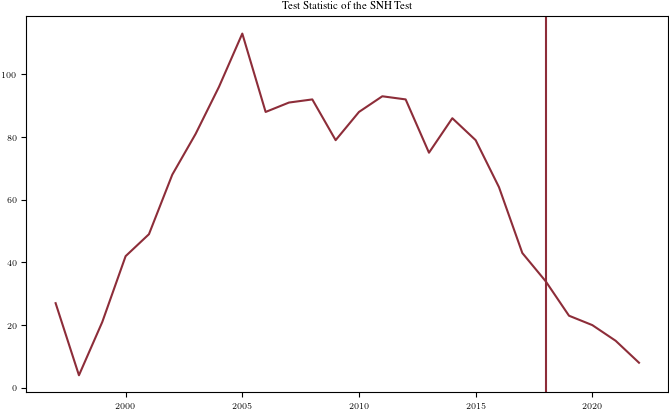

In [29]:

print(hg.pettitt_test(mean_df))
print(hg.snht_test(mean_df))

plt.plot(mean_df.index, pettitt_test(mean_df['Mean']))
plt.axvline(x=2018)
plt.title('Test Statistic of the Pettitt Test')
plt.show()

plt.plot(mean_df.index, pettitt_test(mean_df['Mean']))
plt.axvline(x=2018)
plt.title('Test Statistic of the SNH Test')
plt.show()
